# <center>  Python for biologists

## Lecture 17, Iterators
24.02.2024


> Nikita Vaulin, vaulin@ro.ru, tg: @nvaulin
    

Это кажется для кого-то будет самая сложная лекция нашего курса. Как минимум из-за большого количетсва новой и путанной терминологии. Это нормально. На практике все станет чуть проще. А вообще я сам лично понял эту тему только когда готовил эту лекцию. 

### <center> Let's move on!

---

# Итерируемые объекты, итераторы и генераторы

В питоне существует некоторое разделение объектов, имееющих отношение к процессу **итерации**. Выделяют **итерируемые объекты (Iterables)**, **итераторы (Iterators)** и **генераторы (Generators)**. Они обладают некоторыми отличительными особенностями и в этой лекции мы разберём как они работают и где их использовать.


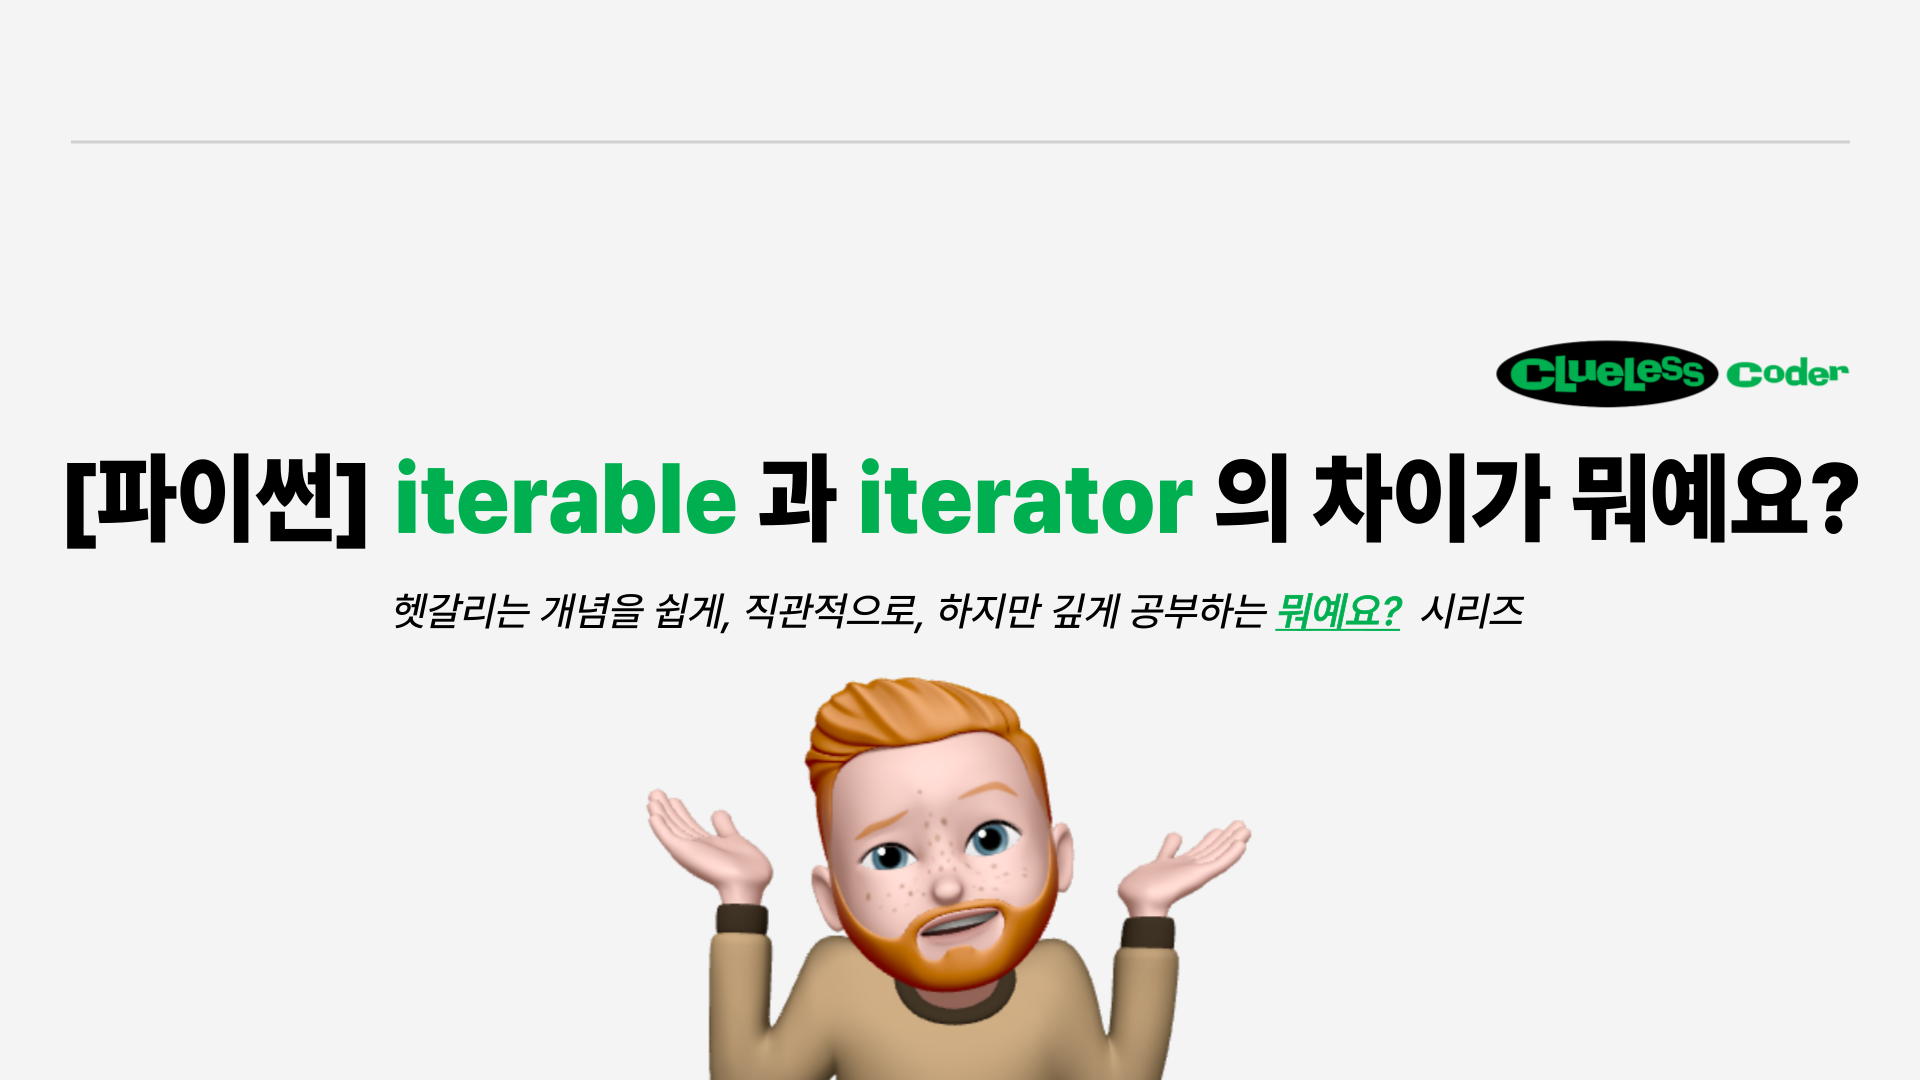


Краткая сводная таблица

| Объект    | По-русски     | Суть     | Начинка |
|---------|---------|---------|---------|
| Iterables | Итерируемые | Можно перебрать в цикле `for`    |  Реализован дандер `__iter___` |
| Iterators   | Итераторы   | Можно доставать элементы по-одному | Реализован дандер `__next___`  |
| Generators   | Генераторы   | Функция с отложенным выполнением (функция-итератор) | Используется ключевое слово `yield`  |

Да, по колонке "Суть" может казаться что Iterables и Iterators это одно и то же. Но это оказывается не так. В этой лекции мы разберем почему так. Но для начала советую запомнить и выписать себе какой дандер какому объекту соотвествует

Сразу, не вдаваясь глубоко в обсуждение, стоит упомянуть, что **генераторы являются подмножеством итераторов**, а **итераторы являются подмножеством итерируемых объектов** (за небольшим исключением). Данную иерархию можно отобразить при помощь следующей диаграмы, на неё также нанесены примеры подобных объектов

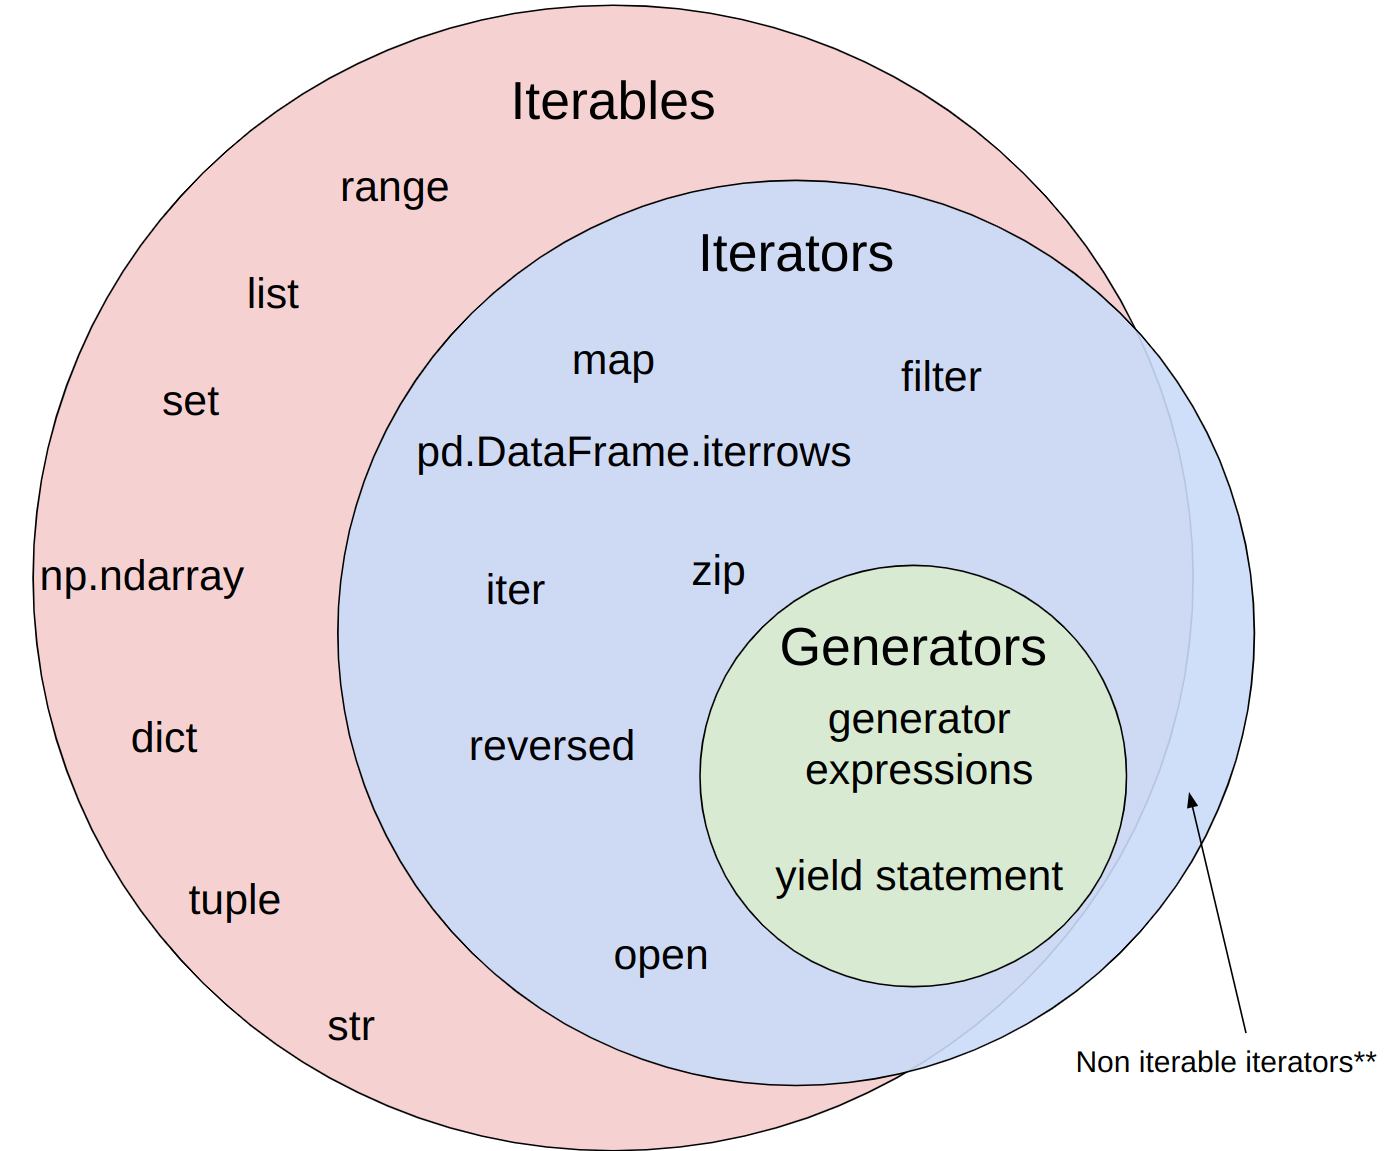

# Сперва пощупаем как это работает

## Итерируемые объекты

- Можно перебирать в цикле `for`
- Имеют дандер `__iter__` (тем самым "реализуют интерфейс Iterables")

Дандер `__inter__` определяет что выдаст вызов встроенной функции `iter(obj)` (ровно как `__len__` задает правила работы `len(obj)`). По сути `iter(obj)` это то же что и `obj.__iter__()`. С `__iter__` есть одно главное правило чтобы всё работало:

> **Дандер-метод `__iter__` должен возвращать итератор (Iterator)**

Этот итератор может работать как угодно и хоть падать с ошибкой при первом же использовании, но он должен возвращаться и должен быть итератором. Таким образом мы получаем еще один сложно-запутанный факт:

> Итерируемые объекты имеют дандер `__iter__` который возвращает итератор

Таким образом итерируемые объекты могут не быть итераторами сами, но любой итерируемый объект можно превратить в итератор вызвав `iter(obj)`. 

Давайте это и проверим:

In [1]:
my_list = [1, 2, 3]
my_set = {1, 2, 3}
my_tuple = (1, 2, 3)

print(type(my_list), type(my_set), type(my_tuple), sep='\n')

<class 'list'>
<class 'set'>
<class 'tuple'>


In [2]:
my_list_iter = iter(my_list)
my_set_iter = iter(my_set)
my_tuple_iter = iter(my_tuple)

print(type(my_list_iter), type(my_set_iter), type(my_tuple_iter), sep='\n')

<class 'list_iterator'>
<class 'set_iterator'>
<class 'tuple_iterator'>


И даже всем вам хорошо знакомый `range`. Как видите, строго по определению он является итерируемым, но не итератором.

In [3]:
my_range = range(5)
print(type(my_range))

<class 'range'>


In [4]:
print('__iter__' in dir(type(my_range)))
print('__next__' in dir(type(my_range)))

True
False


Но, как любой уважающий себя Iterables, он *может* вернуть итератор:

In [5]:
print(type(iter(my_range)))

<class 'range_iterator'>


Как мы видим, действительно вызовы `iter` от итерируемых объектов возвращают итераторы. При чем в данном случае здесь итераторы не голые, а "помнят" тип объекта от которого были порождены, но это не важно и можете не обращать на это внимание. 

Теперь получается мы утыкаемся вы ключевой вопрос: а что же такое тогда итераторы? Давайте разбираться

## Итераторы

- Можно доставать элементы по-одному
- Имеют дандер `__next__` 

Дандер `__next__` определяет что выдаст вызов встроенной функции `next(obj)`. По сути `next(obj)` это то же что и `obj.__next__()`. С `__next__` есть следующие правила

 - Вызов функции next возвращает какой-то объект
 - Это может быть что угодно, правила задаете вы сами
 Главное:
> - **Итератор помнит свое состояние и при каждом новом вызове `next` способен порождать следующий заданный правилами объект**
 - Правила порождения нового объекта могут быть любые, хоть полный рандом, но главное это умение пораждать новые объекты по-одному
 - "По-одному" здесь значит что итератор можно представить как коллекция которую вам дают не всю сразу, а по-элементно. При этом на каждом отдельном шаге может возвращатья не обязательно 1 объект. Например, можно написать итератор который при каждом вызове `next` будет генерировать 5 случайных чисел.

У итератора есть 3 характеристики:
- Набор объектов которые итератор планирует возвращать
- Состояние в котором находится итератор (итератор помнит какие объекты уже вернул и какой он вернет вам при следующем запросе)
- В какой момент остановиться

Остановится итератор тогда и ровно тогда, когда внутри него выбросится исключение `StopIteration` (это не ошибка (Error), а исключение (Exception)). 

- Если вызывать `next()` нужное количество раз и дойти до ошибки `StopIteration`, то на этом **итератор "исчерпается"** и новые вызовы `next()` будут раз за разом давать `StopIteration`. Чтобы заново проитерироваться по "исчерпанному" итератору остается разве что пересоздать его с нуля. 

В связи с этим чтобы в будущем не выстрелить себе в ногу, совет:

> **Не переиспользуйте итераторы**

В принципе, можно написать итератор у которого в методе `__next__` нигде не будет строчки `raise StopIteration`. Такой итератор будет работать вечно. 

### Примеры для понимания.

##### Аналогия - ГПСЧ

ГПСЧ всегда стартует с определенного места (seed). С каждым вызовом ГПСЧ  генерирует новое состояние (по заданным правилам) и  переходит в него


##### Пример - чтение файла

Мне кажется вы тут сможете легко понять все на примере `with open(file) as f`. Здесь по сути `f` (file handler) и является итератором:

1. Он умеет по одному возвращать вам некоторые объекты (`next(obj) <=> f.readline()`)
2. При этом он помнит свое состояние (какие строки уже прочитаны). При новом вызове file handler выдаст вам *следующую* строку файла
3. Если дойти до конца файла (в python нет конкретного символа конца файла типа EOF, там просто пустая строка), то file handler "исчерпается". При каждом новом запросе `f.readline()` он будет возвращать пустую строку (так как строк больше нет).


Давайте посмотрим как оно работает:

In [6]:
print(my_list) # вот наш список

my_list_iter = iter(my_list) # получили из него итератор
print(type(my_list_iter)) # это правда итератор
      
print(next(my_list_iter)) # начали перебирать элементы, вот первый
print(next(my_list_iter)) # далее второй
print(next(my_list_iter)) # и вот третий
print(next(my_list_iter)) # а далее исключение StopIteration

[1, 2, 3]
<class 'list_iterator'>
1
2
3


StopIteration: 

In [7]:
print(next(my_list_iter)) # еще раз попросим next - снова StopIteration

StopIteration: 

При этом сам список (как и другие Iterables) итератором не является. В этом можно убедиться если вызвать `next` прям у списка:

In [8]:
print(my_list)
print(next(my_list))

[1, 2, 3]


TypeError: 'list' object is not an iterator

То есть мы:
- Умеем итерироваться по элементам списка
- Но не умеем доставать элементы из списка по одному с помощью next

Хотя по факту умеем, для этого и есть функция `iter` для превращения Iterables в Iterator

Ещё одно свойство итераторов - **у итераторов нельзя брать элементы по индексу**. Единственное, что они умеют - **отдавать элементы по одному**

In [9]:
my_list_iter = iter(my_list) 
print(my_list[0])  # Список может выдать нулевой элемент
print(my_list_iter[0])  # А итератор не может

1


TypeError: 'list_iterator' object is not subscriptable

Еще один момент который стоит обсудить. Функция `iter` от Iterables возвращает итератор. Что же вернет `iter` от итератора?
Пару примеров для подсказки:
```python
int(5) = ?
str('ABC') = ?
```

Да, все верно, `iter` от итератора вернет сам же этот итератор. В математике такое называется [Идемпотентностью](https://ru.wikipedia.org/wiki/%D0%98%D0%B4%D0%B5%D0%BC%D0%BF%D0%BE%D1%82%D0%B5%D0%BD%D1%82%D0%BD%D0%BE%D1%81%D1%82%D1%8C) или [Проективными операциями](https://en.wikipedia.org/wiki/Projection_(linear_algebra)) - в первый раз функция сделает какое-то преобразование, но во все повторые разы результат будет оставаться тем же самым

## Цикл `for`

### Итераторы и `for`

Все (почти-почти) все итераторы являются итерируемыми объектами, то есть их можно обойти в цикле `for` (см. диаграмму в начале лекции). На самом деле именно **итераторы делают объекты итерируемыми**. Если у объекта нет итератора, то этот объект не является итерируемым и не работает с циклом `for`. 

In [10]:
print('Iterables')
for el in my_list:
    print(el)
    
print('\n')

my_list_iter = iter(my_list)
print('Iterator')
for el in my_list_iter:
    print(el)

Iterables
1
2
3


Iterator
1
2
3


In [11]:
# При этом еще раз обойти итератор не получится:
print('Same Iterables again')
for el in my_list:
    print(el)
    
print('\n')
print('Same Iterator again')
for el in my_list_iter:
    print(el)

Same Iterables again
1
2
3


Same Iterator again


Почему? Потому что наш итератор...

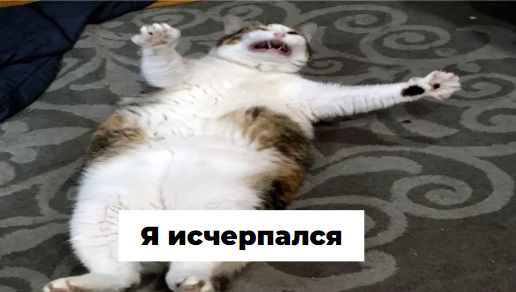


Вопрос - почему мы тут не видим никаких исключений а-ля `StopIteration` и ничего не падает? Чтобы ответить на этот вопрос достаточно посмотреть на то, как цикл `for` устроен внутри.

### Реализация цикла `for`

По сути `for` написал на C++, но на python его можно было бы перевести следующим образом:

In [12]:
my_list = [1, 2, 3]

# Цикл for
for el in my_list:
    print(el) # тут любой внутренний код

1
2
3


In [13]:
# Реализация
obj_iterator = iter(my_list)
while True:
    try:
        el = next(obj_iterator)
        print(el) # тут любой внутренний код
    except StopIteration:
        break

1
2
3


Поэтому если мы еще раз прогоним цикл на том же итераторе, то мы сразу попадем в `except`:

In [14]:
while True:
    try:
        el = next(obj_iterator)
        print(el) # тут любой внутренний код
    except StopIteration:
        print('Wow, StopIteration!') # добавил печать для наглядности
        break

Wow, StopIteration!


# Как написать свой итерируемый объект?

Что нужно чтобы реализовать свой итерируемый объект? Правильно, класс с методом `__iter__` (см. определение в начале лекции)

In [20]:
class MyIterable():
    def __iter__():
        pass

In [21]:
from collections.abc import Iterator, Iterable

print('Iterable:', isinstance(MyIterable(), Iterable))
print('Iterator:', isinstance(MyIterable(), Iterator))

Iterable: True
Iterator: False



Как видите, даже такой пустой "болванки" уже достаточно). Однако чтобы все работало (и в первую очередь цикл `for`) надо написать код `__iter__` так чтобы там был return итератора. Какого не важно, но главное чтобы был.

Давайте сделаем какой-нибудь простой осмысленный пример.

## Пример 1. Банальный

> Объект который при инициализации ожидает целое положительное число $a$ и при итерации по нему выдает все числа от $-a$ до $+a$

In [22]:
class MyIterable():
    def __init__(self, val):
        self.val = val
        
    def __iter__(self):
        return iter(range(-self.val, self.val + 1))

In [23]:
my_iterable = MyIterable(2)
for el in my_iterable:
    print(el)

-2
-1
0
1
2


Здесь главное не забыть два момента:
1. Создавая набор чисел через range - надо увеличить end на 1 (так как правая граница не включается)
2. Метод `__iter__` обязан возвразать итератор, а `range` это лишь iterable, поэтому мы сделали `iter(range)`

Без (1) просто работало бы (но не верно), а без (2) падало бы с ошибкой:

In [24]:
class MyIterable():
    def __init__(self, val):
        self.val = val
        
    def __iter__(self):
        return range(-self.val, self.val+1)
    
my_iterable = MyIterable(2)
for el in my_iterable:
    print(el)

TypeError: iter() returned non-iterator of type 'range'

## Пример 2. Сумасшедший

По факту питону и не важно какие у вас правила создания итератора в `__iter__`. Они могут быть даже никак и не связаны с данными на входе:)

In [25]:
class MyIterable():
    def __init__(self, val):
        self.val = val
        
    def __iter__(self):
        return iter((1, )) # итератор от кортежа с одной единственной единицей

In [26]:
for el in MyIterable(2000):
    print(el)

1


In [27]:
for el in MyIterable('ABC'):
    print(el)

1


# Как написать свой итератор?
 
Все это время мы превращали любые другие объекты в итераторы с помощью `iter`. Формально остался последний вопрос - как написать свой итератор? 

Два факта:
1) Итератор это то, у чего есть метод `__next__`
2) 99% процентов итераторов являются итерируемыми объектами (см. диаграму в начале лекции). Уникальный 1% экзотики мы пока затрагивать не будем. Поэтому фактически у итераторов есть и метод `__iter__`. Если его нет, то мы получим т.н. "неитерируемый итератор", и мы будем игнорировать эту штуку для простоты.

In [28]:
class MyIterator():
    def __init__():
        pass
        
    def __iter__():
        pass
    
    def __next__():
        pass

Вопрос на засыпку. 
> Что должен возвращать метод `__iter__` у итератора?

Ответ: Мы знаем что `__iter__` должен возвращать итератор. Но ведь сам наш объект и является итератором. Поэтому мы можем себя же и вернуть!

По факту так и делают да, реализуют метод `__next__` (что дает итератор) а в `__iter__` возвращают себя (так как надо вернуть итератор, которым мы и являемся).
 

In [30]:
class MyIterator():
    def __init__(self):
        pass
        
    def __iter__(self):
        return self
    
    def __next__(self):
        pass

Осталось только реализовать логику `__iter__` и `__next__`. По сути - задать правила по которым итератор задает и помнит свое состояние, а также по которым он знает как переходить к следующему

## Пример 3. Итератор по четным чиселам

> Задача: реализовать итератор, который будет принимать на вход число и при вызове метода `__next__` будет возвразать четные не более заданного числа (положительные, целые) 

In [31]:
class MyIterator():
    def __init__(self, value):
        self.value = value
        self.current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        current_value = self.current
        if current_value > self.value:
            raise StopIteration
        self.current += 2
        return current_value

In [32]:
my_iterator = MyIterator(3)

In [33]:
next(my_iterator)

0

In [34]:
next(my_iterator)

2

In [35]:
next(my_iterator)

StopIteration: 

То же саме в цикле:

In [36]:
for el in my_iterator:
    print(el)


Вопрос: почему пустой вывод??

Ответ: мы исчерпали итератор. Переопределим его.

In [37]:
my_iterator = MyIterator(3)
for el in my_iterator:
    print(el)

0
2


Да, если кто-то попользуется нашим итератором частично до цикла, то в цикл придет уже б/у-шный итератор:

In [38]:
my_iterator = MyIterator(9)
print('Попользовались итератором пока никто не видит')
print(next(my_iterator))
print(next(my_iterator))

print('\nА теперь в цикле:')
for el in my_iterator:
    print(el)

Попользовались итератором пока никто не видит
0
2

А теперь в цикле:
4
6
8


Он реально помнит свое состояние!

## Пример 4. Итератор по fastq-записи

> Задача: реализовать итератор, который будет принимать на вход 4 строки (имя, коммент, последовательность, качество) и на каждом вызове итератора возвращает следующий по порядку нуклеотид и его качество

In [39]:
class FastqIterator():
    def __init__(self, name, comment, seq, qual):
        self.name = name
        self.comment = comment
        self.seq = seq
        self.qual = qual
        
        self.current_pos = 0
        self.length = len(self.seq)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        current_pos = self.current_pos
        if current_pos == self.length:
            raise StopIteration
        self.current_pos += 1
        return self.seq[current_pos], self.qual[current_pos]

In [40]:
my_fastq = FastqIterator('Seq1', '+', 'ATGC', 'F%F%')

In [41]:
next(my_fastq)

('A', 'F')

In [42]:
next(my_fastq)

('T', '%')

In [43]:
my_fastq = FastqIterator('Seq1', '+', 'ATGC', 'F%F%')
for el in my_fastq:
    print(el)

('A', 'F')
('T', '%')
('G', 'F')
('C', '%')


## Итератор связанный с объектом

В предыдущем примере мы получили объект типа FastqIterator, который:
- Хранит данные fastq
- Итерируемый
- Итератор

Уже в таком небольшом примере это выглядит громоздко. В реальных проектах это может быть совсем ужасно. Поэтому логику "класс для хранения и обработки данных" и логику "итерируемость и итераторность" принято разделять. Для этого делают классы-объекты, а рядом создают классы-итераторы относящиеся к этим объектам. В нашем примере код бы выглядел так:

In [44]:
class FastqIterator():
    def __init__(self, seq, qual):
        self._seq = seq
        self._qual = qual
        
        self.current_pos = 0
        self.length = len(self._seq)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        current_pos = self.current_pos
        if current_pos == self.length:
            raise StopIteration
        self.current_pos += 1
        return self._seq[current_pos], self._qual[current_pos]
    
    
class FastqRecord():
    def __init__(self, name, comment, seq, qual):
        self.name = name
        self.comment = comment
        self.seq = seq
        self.qual = qual
        
    def __iter__(self):
        return FastqIterator(seq=self.seq, qual=self.qual)

In [45]:
my_fastq = FastqRecord('Seq1', '+', 'ATGC', 'F%F%')

In [46]:
print(my_fastq)
print(iter(my_fastq))

In [47]:
next(my_fastq)

TypeError: 'FastqRecord' object is not an iterator

In [48]:
next(iter(my_fastq))

('A', 'F')

In [49]:
my_fastq = FastqRecord('Seq1', '+', 'ATGC', 'F%F%')
for el in my_fastq:
    print(el)

('A', 'F')
('T', '%')
('G', 'F')
('C', '%')


Таким образом если мы хотим отрефакторить саму структуру данных (ex. добавить новый метод), то мы никак не рискуем поломать его итерируемость. Если же мы захотим изменить правила работы в цикле `for`, то но нам не нужно копаться во всем основном классе.

# Генераторы

- Генераторы по своей роли **это альтернативный способ создания итераторов**.
- Генераторы по своей начинке **это функция содержащая ключевое слово yield**

`yield` это какой-то пятидесятиюродный брат близнец `return`. 

In [50]:
def my_generator():
    yield 3

> **Генераторы возвращают итераторы** (иногда в моей голове это все начинает звучать как то [так](http://knigi.kembibl.ru/Knigi/Petrushevskaja_Puski_bjatye.pdf))

- `my_generator` (функция) - генератор
- `my_generator()` (результат функции) - "generator iterator"

В этом плане генератор совсем не обычная функция. Потому что она возвращает не результат, а итератор (хронящий результаты).

In [51]:
my_generator

<function __main__.my_generator()>

In [52]:
my_generator() # никакой тройки не напечаталось

<generator object my_generator at 0x7fa8453e3ab0>

In [53]:
next(my_generator()) # вот она, next-элемент итератора

3

Что это дает? Это реализует концепцию т.п. **"отложенного выполнения"**. Если в генераторе несколько `yield`, то они будут выдавать нам объекты один за другим при каждом `next`-запросе. 

При этом:
- `return ...`
- просто конец функции (~ `return None`)

означают StopIteration.

In [54]:
gen_iter = my_generator()

In [55]:
next(gen_iter)

3

In [56]:
next(gen_iter) # врезались в конец функции

StopIteration: 

In [7]:
def my_generator(n):
    print('Start')
    yield n
    
    if n <= 3:
        print('if-exit')
        return 'Extra-exit'
    
    print('Second yield')
    yield n - 1
    
    print('Third yield')
    yield n - 2    
    
    print('Exit')

In [8]:
gen_iter = my_generator(1)

**Важно** - никакие print не сработали! Код функции вообще не выполнялся!

In [9]:
next(gen_iter) # выполнили все ДО первого yield (включительно)

Start


1

In [10]:
next(gen_iter) # попали в ветку if, конец итерации

if-exit


StopIteration: Extra-exit

При этом по генераторам можно итерироваться:

In [11]:
for el in my_generator(10):
    print('----- for cycle, got:', el)

Start
----- for cycle, got: 10
Second yield
----- for cycle, got: 9
Third yield
----- for cycle, got: 8
Exit


Тут StopIteration просто выбросила нас из цикла.

Таким образом:

Код функции на самом деле не выполняется в данный момент ее создания (def) или вызова. Мы уже выяснили, что функция возвращает нам **генератор**. Код начинает исполняться только в тот момент, когда мы просим у генератора следующий элемент при помощи `next`. При этом исполнение начнётся с начала функции и продолжится до первой инструкции `yield`, а `next` вернёт переменную, указанную в конструкции `yield`, а исполнение функции приостановится на этом моменте. Когда мы вызовем `next` во второй раз, исполнение функции продолжится с момента, где она в последний раз остановилась, и продолжится до следующей инструкции `yield`. Когда инструкции `yield` закончатся и мы дойдём до конца функции при очередном вызове `next`, будет брошена ошибка `StopIteration`

## Польза генераторов

По сути это просто чуть более удобный способ создавать итераторы. Без  всяких классов, дандер-методов и т.д. 

Помните наш "банальный" пример №1? Пример-то банальный, а потребовал от нас: класс, два метода, дандеры, аттрибуты... Просто жесть.

In [62]:
class MyIterable():
    def __init__(self, val):
        self.val = val
        
    def __iter__(self):
        return iter(range(-self.val, self.val + 1))

In [63]:
my_iterable = MyIterable(2)
for el in my_iterable:
    print(el)

-2
-1
0
1
2


То же самое генераторами:

In [64]:
def my_generator(n):
    for i in range(-n, n + 1):
        yield i

In [65]:
for el in my_generator(2):
    print(el)

-2
-1
0
1
2


Как видите, мы создали итератор просто банальнейшей функией с циклом `for` использовав в 2 раза меньше строчек кода.

## Генераторы для создания объектов-итераторов

Все это на самм деле не противоположные вещи, их можно удачно использовать вместе. Например:

In [66]:
class FastqRecord():
    def __init__(self, name, comment, seq, qual):
        self.name = name
        self.comment = comment
        self.seq = seq
        self.qual = qual
        
    def __iter__(self):
        for pos in range(len(self.seq)):
            yield self.seq[pos], self.qual[pos]

In [67]:
my_fastq = FastqRecord('Seq1', '+', 'ATGC', 'F%F%')
for el in my_fastq:
    print(el)

('A', 'F')
('T', '%')
('G', 'F')
('C', '%')


Как видите, мы превратили дандер-метод `__iter__` в генератор, и теперь о возвращает итератор, а питону это и нужно! Все супер. 

Я бы только переписал это вот так (чтобы совсем красиво было):

In [68]:
class FastqRecord():
    def __init__(self, name, comment, seq, qual):
        self.name = name
        self.comment = comment
        self.seq = seq
        self.qual = qual
        
    def __iter__(self):
        for seq, qual in zip(self.seq, self.qual):
            yield seq, qual

In [69]:
my_fastq = FastqRecord('Seq1', '+', 'ATGC', 'F%F%')
for el in my_fastq:
    print(el)

('A', 'F')
('T', '%')
('G', 'F')
('C', '%')


Всё работает точно также, но занимает в разы меньше кода. Во многом именно поэтому создание итерируемых объектов при помощи превращения метода `__iter__` в генератор это state of the art для небольших и средних классов. Генераторы позволяют нам описать всю логику итератора в одном классе с объектом, который должен использовать этот итератор.

Понятон, что генераторы удобном создают итераторы. Однако, тогда встает вопрос, а зачем нам сами итераторы?

# Lazy evaluation

Ключевая польза итераторов - это "ленивые вычисления". Её суть состоит в том, что часть кода выполняется только, когда мы просим это сделать. Когда мы ничего не трогаем, код лишь хранит в себе информацию о текущем состоянии. 

Таким образом мы не храним все данные в памяти, а работаем с ними "на лету". Как раз то, что нам было так важно с файлами. Не читать все разом с `readlines()`, а работать с каждой сторокой по-очереди.

Данная особенность позволяет нам существенно оптимизировать программы по памяти и эффективно обрабатывать огромные объёмы данных, которые сильно превышают размер оперативной памяти.

In [70]:
with open("Lecture_17_Iterators.ipynb", "rb") as file:
    print(next(file))
    file.seek(0)
    print(file.__next__())
    file.seek(0)
    print(file.readline())

b'{\n'
b'{\n'
b'{\n'


# Полезные итераторы и итерируемые объекты

## `range` 

> Итерируемый объект (работает с `for`, но не с `next`)

Вот теперь мы понимаем, почему нам нужно делать `list(range)` чтобы получить все элементы. Но, точнее, не нужно. Если вы используете range в for, то вам не надо разом хранить всё его содержимое. Просто перебирайте элементы.

In [71]:
print(range(5))
print(type(range(5)))
print(list(range(5)))

range(0, 5)
<class 'range'>
[0, 1, 2, 3, 4]


In [72]:
next(range(5))

TypeError: 'range' object is not an iterator

In [73]:
%%timeit 

for i in range(int(1e7)):
    pass

104 ms ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
%%timeit 

for i in list(range(int(1e7))):
    pass

215 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Разница не такая огромная, но чем сложнее данные тем больше она будет заметна.

## `map` 

> Позволяет применить некоторую функцию к набору данных

`map(f, xs)` $\Leftrightarrow f(x_1), f(x_2), ... f(x_i) \forall i \in len(xs)$

Возвращает итератор (работает и с `for` и с `next`). То есть результаты $f(x_i)$ вычисляются не все разом, а один за одном "по тебованию".

### Пример: разворот набора строк

In [75]:
def reverse(seq):
    return seq[::-1]

res = map(reverse, ['ATGC', 'TG', 'TTG'])

In [76]:
print(res)

In [77]:
list(res)

['CGTA', 'GT', 'GTT']

In [78]:
for el in res:
    print(el)

Почему ничего не напечаталось? Не забывайте что итераторы имеют свойство исчерпываться!

In [79]:
for el in map(reverse, ['ATGC', 'TG', 'TTG']):
    print(el)

CGTA
GT
GTT


### Пример: приведение типов данных

In [80]:
list(map(int, ['1', '2', '3']))

[1, 2, 3]

In [81]:
list(map(str, [3.14, 15, 926, 5.35]))

['3.14', '15', '926', '5.35']

Теперь вы понимаете что реально значит такая частовстречаемая конструкция как:

```python
map(int, input())
```

## Интерлюдия: привет от функционального программирования 

**OOP:** *x* $\rightarrow$  `x.f()` & `x.g()` & `x.h()` $\rightarrow$ *result* </br>
Модификация данных методами

**FP:** *x* $\rightarrow f(x) \rightarrow g(f(x)) \rightarrow h(g(f(x))) \rightarrow$ *result* </br>
Передача данных через функции


`map` - один из ключевых элементов ФП-стороны python. Он как раз занимается тем чтобы применять функции к данным, при чем делает это "экономно" - хранит результат в виде итератора. Существуют также еще `filter` и целая уйма всего в модуле [functools](https://docs.python.org/3/library/functools.html). Например, если интересно, можете обратить внимание на `reduce` и `partial`.

Вот задания которые может быть полезно сделать если вам интерено ФП:

1) Напишите функцию `sequential_map` - функция должна принимать в качестве аргументов любое количество функций (позиционными аргументами, не списком), а также контейнер с какими-то значениями. Функция должна возвращать список результатов последовательного применения переданных функций к значениям в контейнере. Например:

```python
res = sequential_map(np.square, 
                     np.sqrt, 
                     lambda x: x**3, 
                     [1, 2, 3, 4, 5])
print(res)
>>> [1, 8, 27, 64, 125]
```

2) Напишите функцию `consensus_filter` -  функция должна принимать в качестве аргументов любое количество функций (позиционными  аргументами, НЕ списком), возвращающих True или False, а также контейнер с какими-то значениями. Функция должна возвращать список значений, которые при передаче их во все функции дают True. Например:

```python
res = consensus_filter(lambda x: x > 0, 
                       lambda x: x > 5, 
                       lambda x: x < 10, 
                       [-2, 0, 4, 6, 11])
print(res)
>>> [6]
```


3) Напишите функцию `conditional_reduce` -  ункция должна принимать 2 функции, а также контейнер с значениями. Первая функция должна принимать 1 аргумент и возвращать True или False, вторая также принимает 2 аргумента и возвращает значение (как в обычной функции reduce). conditional_reduce должна возвращать одно значение - результат reduce, пропуская значения с которыми первая функция выдала False. Например:

```python
res = conditional_reduce(lambda x: x < 5, 
                         lambda x, y: x + y, 
                         [1, 3, 5, 10])
print(res)
>>> 4
```
    
Однако на практике в 90% случаях биоинформатикам нужен лишь `map` и...



### $\lambda$-функции

Это попросту альтернативный механизм создания функций. Выглядит это так:
```python
lambda x, y: print(x + y)
```

Оно состоит из 3-х частей:
1) Ключевое слово `lambda` - объявляет создание $\lambda$-функции
2) Перечесление ожидаемых аргументов
3) Тело функции

При этом как видете во всем этом деле никак не фигурирует имя функции. В теории $\lambda$-функции можно присвоить имя:
```python
f = lambda x, y: print(x + y)
```

Интересно, что здесь немного стираются границы между функциями и переменными. В python есть просто объекты и ссылки на них (имена). При этом имена вообще не знают о том, являются ли объекты под ними callable или нет.

Именования $\lambda$-функции соотвествует записи:
```python
def f(x, y):
    print(x, y)
```

Однако, **не надо именовать $\lambda$-функции**. $\lambda$-функции еще принято называть "анонимными", подчеркивая что им не принято давать имена.

### Зачем нужны $\lambda$-функции?

Чтобы быстро и немногословно определить и сразу же использовать функцию именно там где нужно. 

### Пример $\lambda$-1. Работа с дата-фреймами 

1) Можно лакончино что-нибудь переименовать
2) Можно лаконично что-то сделать с данными

In [82]:
import numpy as np
import pandas as pd

df = pd.DataFrame({'col1_start': [1, 2, 3],
                   'col2_end': [5, 6, 7],
                   'col3_value': [0, 0, 2]
                  })

df

/tmp/ipykernel_4464/2895604234.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,col1_start,col2_end,col3_value
0,1,5,0
1,2,6,0
2,3,7,2


In [83]:
df.rename(lambda x: x.split('_')[1], axis=1) # переименование колонок

,start,end,value
0,1,5,0
1,2,6,0
2,3,7,2


In [84]:
df.apply(lambda x: x / x.sum(), axis=0) # нормировка

,col1_start,col2_end,col3_value
0,0.166667,0.277778,0.0
1,0.333333,0.333333,0.0
2,0.500000,0.388889,1.0


### Пример $\lambda$-2. Соленый язык без проблем с регистром

In [85]:
import re

def salt(text):
    vowels = r'([ауоиэыяюеёАУОИЭЫЯЮЕЁ])'
    return re.sub(vowels, 
                  lambda x: x.group(0) + 'c' + x.group(0).lower(), 
                  text)

In [86]:
salt('Ура!') # дубликат буквы "У" в нижнем регистре

'Уcураcа!'

### Пример $\lambda$-3. Идеальная пара: `map` и $\lambda$-функции

In [87]:
my_list = [11, 21, 51, 101]
res = map(lambda x: x//10, my_list)
list(res)

[1, 2, 5, 10]

### Где испольовать $\lambda$-функции, а где обычные?

- Если код функции не влезает в 1 строчку - вам нужна обычная
- Если функция используется более 1 раза - вам нужна обычная
- Если вам нужно дать функции имя - вам нужна обычная

- Если вам нужно применить небольшую функцию к набору данных - вам нужна $\lambda$-функция

- Если вы не уверены, вам нужна обычная функция

> **Back to** зоопарк итерируемости и итераторности

## `zip` 
  
  > Поэлементно "склеивает" элементы нескольких коллекций (1й с 1м, 2й со 2м и т.п.)

Возвращает итератор (работает и с `for` и с `next`).

При разной длине коллекций ориентируется на наименьшую.

In [88]:
for el in zip(['A', 'B', 'C'], ['a', 'b', 'c']):
    print(el)

('A', 'a')
('B', 'b')
('C', 'c')


### Пример: раскраска графиков

In [89]:
import matplotlib.pyplot as plt

In [90]:
df = pd.DataFrame({'time': [1, 2, 3, 1, 2, 3, 1, 2, 3],
                   'value': [5, 6, 7, 0, 1, 2, 0, 0, 1],
                   'group': ['control', 'control', 'control',
                             'treatment_1', 'treatment_1', 'treatment_1',
                             'treatment_2', 'treatment_2', 'treatment_2']
                  })

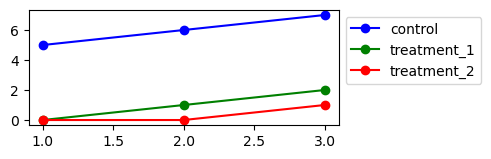

In [91]:
fig = plt.figure(figsize=(4,1.5))
groups = df.group.unique()
for group, color in zip(groups, 
                        ['blue', 'green', 'red']):
    sub_df = df.query('group==@group')
    plt.plot(sub_df['time'],
             sub_df['value'],
             '-o',
             color = color,
             label = group
            )
plt.legend(bbox_to_anchor=(1,1));      

## `enumerate` 
  
  > Поэлементно "склеивает" элементы коллекции с их порядковыми номерами

Возвращает итератор (работает и с `for` и с `next`).

In [92]:
for el in enumerate(['a', 'b', 'c']):
    print(el)

(0, 'a')
(1, 'b')
(2, 'c')


### Пример: панели графиков

`enumerate` отлично подходит когда нужно в цикле что-то строить на разных осяx.

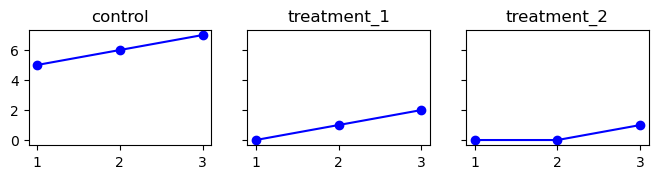

In [93]:
fig, axs = plt.subplots(ncols=3, figsize=(8,1.5), sharey=True)
groups = df.group.unique()

for i, group in enumerate(groups):
    sub_df = df.query('group==@group')
    axs[i].plot(sub_df['time'],
             sub_df['value'],
             '-o',
             color = 'blue'
            )   
    axs[i].set_title(group)

# Модуль [itertools](https://docs.python.org/3/library/itertools.html#module-itertools)

**itertools** - это модуль стандартной библиотеки питона. В нём, как понятно из названия, находятся всяческие функции и классы как-то связанные с итерацией. В частности, там есть много полезных итераторов.


## Комбинаторные итераторы

Это функции `product`, `permutations`, `combinations` и `combinations_with_replacement`. Они позволяют получать нам различные комбинации элементов. Поскольку число комбинаций (речь не о сочетаниях, а о любых комбинаторных наборах данных), как правило, экспоненциально увеличивается с увеличением количества комбинируемых элементов, данные функции представлены именно итераторами. То есть ваши комбинации будут вычисляться сразу по ходу итерации, а не загружаться сразу в память.

Например, функция `combinations` генерирует нам сочетания

In [95]:
import itertools


for comb in itertools.combinations("ABCD", 2):  # Генератор сочетаний длиной 2 без перестановок (это итератор, next с ним работает)
    print(comb)

('A', 'B')
('A', 'C')
('A', 'D')
('B', 'C')
('B', 'D')
('C', 'D')


## Пример: взлом пароля

Например, вы пишите программу для подбора паролей, которая перебирает все возможные пароли из 8 символов.

In [1]:
import string
import itertools

# здесь для простоты возьмем маленькие буквы и цифры
alphabet = string.ascii_lowercase  + string.digits
print(alphabet)
print(len(alphabet))

abcdefghijklmnopqrstuvwxyz0123456789
36


Допустим вот реальный пароль пользователя: 

In [2]:
user_password = '12345678'

**Лучше не запускать код ниже**

```bash
pip install memory_profiler
```

In [3]:
%reload_ext memory_profiler

In [4]:
%%time 
%%memit 

for pswd_chars in itertools.combinations_with_replacement(alphabet, 8):
    password = ''.join(pswd_chars)
    if user_password == password:
        print('Success! The password is:', password)  

Success! The password is: 12345678
peak memory: 71.57 MiB, increment: 0.34 MiB
CPU times: user 16.2 s, sys: 6.57 ms, total: 16.2 s
Wall time: 16.4 s


Возможных комбинаций просто огромное количество, они все просто не смогут поместиться в память, но так мы получаем их по 1, не затрачивая память.

Если бы мы проверяли пароли не "на лету", а получили все разом, то наш компьютер скорее всего умер бы из-за памяти. Видете, что здесь время отличается не сильно, а память прям на порядки.

In [5]:
%%time 
%%memit 

passwords = list(map(lambda x: ''.join(x), itertools.combinations_with_replacement(alphabet, 8)))
for password in passwords:
    if user_password == password:
        print('Success! The password is:', password)  

Success! The password is: 12345678
peak memory: 10065.32 MiB, increment: 9993.73 MiB
CPU times: user 16.4 s, sys: 3.18 s, total: 19.6 s
Wall time: 19.7 s




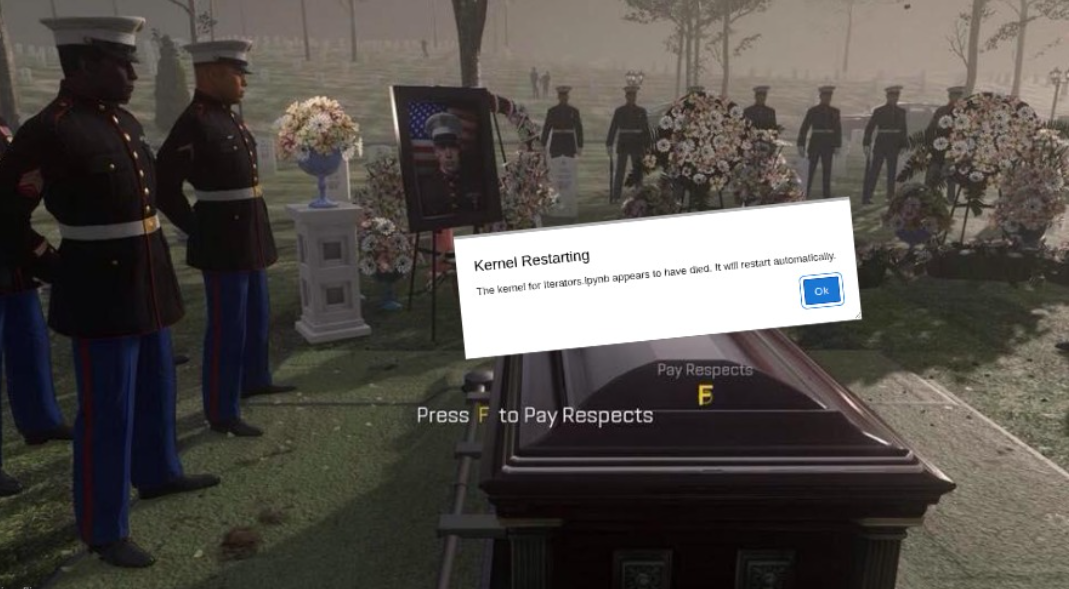

А если же вам просто надо узнать число комбинаций, то не пытайте компьютер вообще и используйте знания математики!

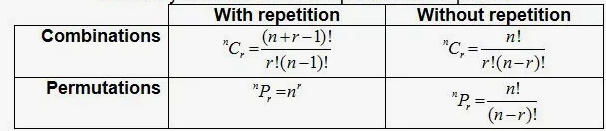

In [7]:
import math
n = len(alphabet)
r = len(user_password)
math.comb(n + r - 1, r) 

145008513

Собственно, столько у нас и вышло))

In [10]:
len(passwords)

145008513

## Аналоги встроенных функций

В `itertools` есть модифицированные аналоги функций `map` и `filter` - [filterfalse](https://docs.python.org/3/library/itertools.html#itertools.filterfalse) и [starmap](https://docs.python.org/3/library/itertools.html#itertools.starmap). Функция [itertools.zip_longest](https://docs.python.org/3/library/itertools.html#itertools.zip_long) делает `zip` подводя все под наибольшую длину. Ну и куча всего другого.

# Всякие интересности


Это вообще бесполезно и не нужно, но просто прикольно!

## Итерируемые объекты через `__getitem__`

Дандер-метод `__getitem__` позволяет нам получать элементы из нашего объекта по индексу и делать срезы. Оказывается, если у вашего класса нету `__iter__`, но есть `__getitem__`, то python попытается запилить итерируемость на его основе.

Как? 

Python просто попробует производить итерацию по объекту, пытаясь получить сначала 0 элемент, затем 1, 2 и т.д.

In [11]:
class MyIterableClass:
    def __init__(self, container):
        self.container = container
        
    def __getitem__(self, idx):
        return self.container[idx]
    

my_iterable = MyIterableClass([5, 4, 3, 2, 1])
for i in my_iterable:
    print(i)

5
4
3
2
1


Тем не менее, итерируемые объекты редко целенаправленно создают через `__getitem__`, это скорее полезный побочный эффект данного метода.

### Генераторы: `yield from`

Инструкция `yield from` позволяет генератору `yield'ить` элементы из какого-то ещё итератора

In [2]:
def generator1():
    for i in range(10):
        yield i
        

def generator2():
    yield 'A'
    yield 'A'
    yield 'A'
    yield 'A'   # До этого момента наш генератор выполняется как обычно, возвращая число при каждом вызове next
    yield from generator1()  # В этот момент мы как бы переключаемся на другой итератор, при этом значения в конце концов будут возвращаться из текущего
    yield 'B'  # А после исчерпания итератора на строке выше, мы продолжим yield'ить из текущего
    yield 'B'

In [3]:
list(generator2())

['A', 'A', 'A', 'A', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'B', 'B']

Альтернативно,

```python
yield from generator1()
```
можно было бы записать вот так
```python
for item in generator1():
    yield item
```
Два данных куска кода делают абсолютно одно и тоже, так что `yield from` это просто синтаксический сахар

## Генераторы: `.send`


Метод `send` генератора позволяет нам отправлять значения к нему внутрь. Для этого требуется конструкция вида
```python
recieved_value = yield variable
```

В `recieved_value` попадёт то, что мы передаём в `send`. По факту обычный `next(gen))` делает `.send(None)`, а обычный `yield` принимает его никуда не сохраняя.

In [20]:
def generator():
    for i in range(3):
        recieved_value = yield i
        print(recieved_value)
        

gen = generator()
print(next(gen))
print(gen.send("This message was sent to generator"))
print(next(gen))

0
This message was sent to generator
1
None
2


 При этом мы не можем начать исполнение генератора с "наполненного" вызова `send`. Первым обязательно должен быть вызов `next` `.send(None)`.

## Генераторы: `return`

Внимательные могли заметить странность в разобранном нами примере:


In [21]:
def my_generator(n):
    print('Start')
    yield n
    
    if n <= 3:
        print('if-exit')
        return 'Extra-exit'
    
    print('Second yield')
    yield n - 1
    
    print('Third yield')
    yield n - 2    
    
    print('Exit')

In [22]:
gen_iter = my_generator(2)
print(next(gen_iter))
print(next(gen_iter))
print(next(gen_iter))
print(next(gen_iter))

Start
2
if-exit


StopIteration: Extra-exit

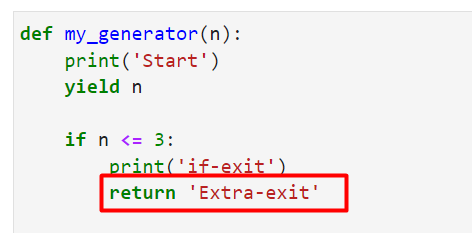

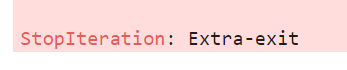

Да, `return` просто бросает `StopIteration` с указанным текстом

## Генераторные выражения (generator expressions)

Создавать генераторы в питоне можно в одну строку, для этого есть синтаксис аналогичный *list comprehensions*, но только здесь используются круглые скобки ()

In [23]:
generator = (item for item in range(10))

print(type(generator))  # Это генератор
print(next(generator))  # next работает
print(generator[0])     # Индексация не работает

<class 'generator'>
0


TypeError: 'generator' object is not subscriptable

Интересный факт! Когда вы пишете следующий код

In [24]:
sum(i for i in range(10))

45

Внутри `i for i in range(10)` это тоже генераторное выражение, а не список, как вы могли бы подумать